In [1]:
from pathlib import Path
import pandas as pd
import json
from shapely.geometry import shape, Point
from shapely.ops import unary_union

# ---------- chemins ----------
HERE = Path().resolve()      # zfe-scm/
ROOT = HERE.parent           # racine du projet
DATA = ROOT / "data"

# 🔁 mets à jour le nom du fichier si tu le renommes
CSV_FILE = "Export Moy. journalière - 20251205114649 - 2017-08-17 00_00 - 2025-12-04 11_00.csv"
csv_path = DATA / CSV_FILE

# ---------- 1) charger & nettoyer le CSV NO₂ Paris ----------
df_raw = pd.read_csv(csv_path, sep=";", engine="python")

# garder uniquement NO₂
df_no2 = df_raw[df_raw["Polluant"] == "NO2"].copy()

# colonne date
date_col = [c for c in df_no2.columns if "Date de début" in c][0]
df_no2["date"] = pd.to_datetime(df_no2[date_col])

# lat / lon en float
df_no2["lat"] = df_no2["Latitude"].astype(float)
df_no2["lon"] = df_no2["Longitude"].astype(float)

# dataframe propre au format "maison"
no2_paris_daily = (
    df_no2.rename(columns={
        "code site": "station_id",
        "nom site": "station_name",
        "type d'implantation": "station_env",
        "type d'influence": "station_influence",
        "valeur": "no2_ug_m3",
    })[
        ["date", "station_id", "station_name",
         "station_env", "station_influence",
         "no2_ug_m3", "lat", "lon"]
    ]
    .sort_values(["station_id", "date"])
    .reset_index(drop=True)
)

print("Aperçu NO₂ Paris :")
display(no2_paris_daily.head())
print("Stations Paris dans ce fichier :")
display(no2_paris_daily[["station_id", "station_name"]].drop_duplicates())

# ---------- 2) charger la ZFE Paris depuis aires.geojson ----------
with open(DATA / "aires.geojson", encoding="utf-8") as f:
    gj = json.load(f)

paris_feats = [
    ft for ft in gj["features"]
    if ft.get("publisher", {}).get("zfe_id") == "PARIS"
]

if not paris_feats:
    raise ValueError("Impossible de trouver une ZFE avec publisher.zfe_id == 'PARIS' dans aires.geojson")

paris_geom = unary_union([shape(ft["geometry"]) for ft in paris_feats])

# ---------- 3) construire le meta stations + in_zfe_paris ----------
stations_meta = (
    no2_paris_daily
    .groupby(["station_id", "station_name",
              "station_env", "station_influence"])[["lat", "lon"]]
    .first()
    .reset_index()
)

stations_meta["in_zfe_paris"] = stations_meta.apply(
    lambda row: paris_geom.contains(Point(row["lon"], row["lat"])),
    axis=1
)

print("Meta stations Paris (+ in_zfe_paris) :")
display(stations_meta)

# ---------- 4) sauvegarde des CSV propres ----------
no2_paris_daily.to_csv(DATA / "pollution_paris_no2_daily_clean.csv", index=False)
stations_meta.to_csv(DATA / "no2_paris_stations_meta.csv", index=False)

print("Fichiers sauvegardés :")
print(" - pollution_paris_no2_daily_clean.csv")
print(" - no2_paris_stations_meta.csv")


Aperçu NO₂ Paris :


,date,station_id,station_name,station_env,station_influence,no2_ug_m3,lat,lon
0,2017-08-17,FR04031,Av Champs Elysees,Urbaine,Trafic,27.0,48.868772,2.311231
1,2017-08-18,FR04031,Av Champs Elysees,Urbaine,Trafic,38.0,48.868772,2.311231
2,2017-08-19,FR04031,Av Champs Elysees,Urbaine,Trafic,32.0,48.868772,2.311231
3,2017-08-20,FR04031,Av Champs Elysees,Urbaine,Trafic,32.0,48.868772,2.311231
4,2017-08-21,FR04031,Av Champs Elysees,Urbaine,Trafic,37.0,48.868772,2.311231


Stations Paris dans ce fichier :


,station_id,station_name
0,FR04031,Av Champs Elysees
3015,FR04055,PARIS 1er Les Halles


Meta stations Paris (+ in_zfe_paris) :


,station_id,station_name,station_env,station_influence,lat,lon,in_zfe_paris
0,FR04031,Av Champs Elysees,Urbaine,Trafic,48.868772,2.311231,True
1,FR04055,PARIS 1er Les Halles,Urbaine,Fond,48.862120,2.344616,True


Fichiers sauvegardés :
 - pollution_paris_no2_daily_clean.csv
 - no2_paris_stations_meta.csv


Stations disponibles à Paris :


,station_id,station_name,in_zfe_paris
0,FR04031,Av Champs Elysees,True
1,FR04055,PARIS 1er Les Halles,True


Aperçu mensuel :


,station_id,station_name,date,no2_ug_m3
0,FR04031,Av Champs Elysees,2017-08-01,44.600000
1,FR04031,Av Champs Elysees,2017-09-01,51.700000
2,FR04031,Av Champs Elysees,2017-10-01,51.258065
3,FR04031,Av Champs Elysees,2017-11-01,54.000000
4,FR04031,Av Champs Elysees,2017-12-01,49.645161


Début ZFE Paris : 2021-06-01


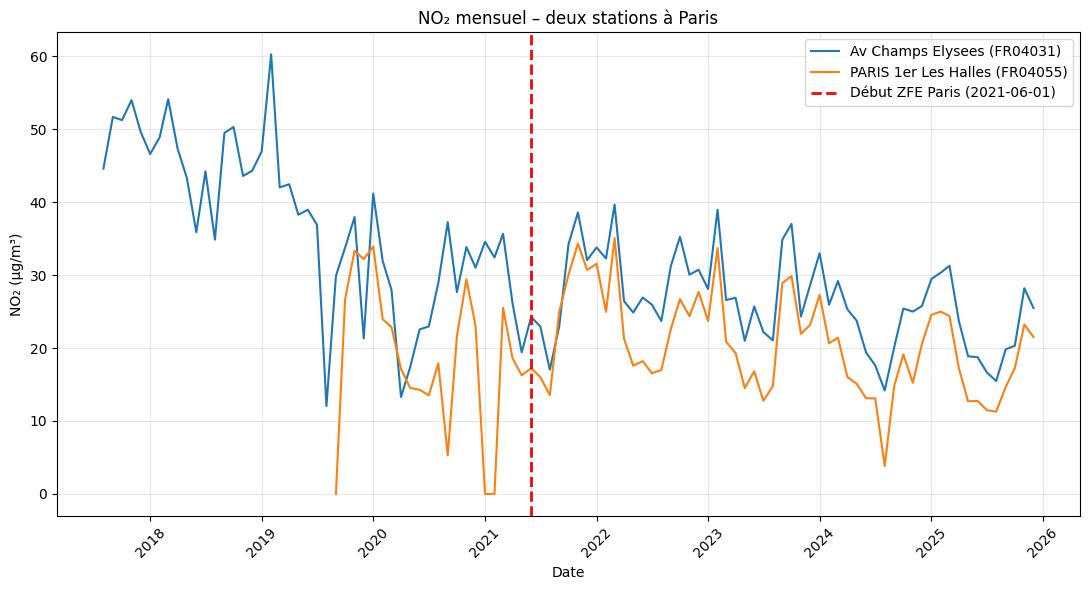

In [3]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# ---------- chemins ----------
HERE = Path().resolve()      # zfe-scm/
ROOT = HERE.parent           # racine du projet
DATA = ROOT / "data"

# ---------- 1) charger les données ----------
no2_paris = pd.read_csv(DATA / "pollution_paris_no2_daily_clean.csv")
no2_paris["date"] = pd.to_datetime(no2_paris["date"])

stations_meta = pd.read_csv(DATA / "no2_paris_stations_meta.csv")

print("Stations disponibles à Paris :")
display(stations_meta[["station_id", "station_name", "in_zfe_paris"]])

# ---------- 2) choisir les deux stations ----------
station_ids = ["FR04031","FR04055"
    # ex : "FRXXXX1", "FRXXXX2"
]

if len(station_ids) != 2:
    raise ValueError("Renseigne exactement 2 station_id dans la liste station_ids.")

no2_sel = no2_paris[no2_paris["station_id"].isin(station_ids)].copy()

# ---------- 3) agrégation mensuelle ----------
monthly = (
    no2_sel
    .set_index("date")
    .groupby(["station_id", "station_name"])["no2_ug_m3"]
    .resample("MS")  # début de mois
    .mean()
    .reset_index()
)

print("Aperçu mensuel :")
display(monthly.head())

# ---------- 4) date de début ZFE Paris ----------
zfe_meta = pd.read_csv(DATA / "zfe_meta.csv")
paris_row = zfe_meta.loc[zfe_meta["publisher_zfe_id"] == "PARIS"].iloc[0]
zfe_start = pd.to_datetime(paris_row["first_date_debut"])
zfe_start_month = zfe_start.to_period("M").to_timestamp()
print("Début ZFE Paris :", zfe_start.date())

# ---------- 5) tracé ----------
plt.figure(figsize=(11, 6))

for (sid, name), sub in monthly.groupby(["station_id", "station_name"]):
    plt.plot(sub["date"], sub["no2_ug_m3"], label=f"{name} ({sid})")

plt.axvline(
    zfe_start_month,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Début ZFE Paris ({zfe_start_month.date()})",
)

plt.title("NO₂ mensuel – deux stations à Paris")
plt.xlabel("Date")
plt.ylabel("NO₂ (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
